In [1]:
# Import các thư viện cần thiết
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [3]:
train_dir = 'train'  # Thay đường dẫn nếu cần
test_dir = 'test'    # Thay đường dẫn nếu cần

classes = os.listdir(train_dir)

label2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2label = {idx: cls for cls, idx in label2idx.items()}

In [4]:
test_img_path = os.path.join(train_dir, classes[0], os.listdir(
    os.path.join(train_dir, classes[0]))[0])
img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
img_height, img_width = img.shape
print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

Image height: 48
Image width: 48


In [5]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=train_ratio,
                random_state=random_state,
                stratify=self.img_labels
            )

            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = read_image(img_path)
        img = self.resize(img)
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img / 127.5) - 1
        return img, label

In [6]:
# Tạo DataLoader cho tập train, val và test
batch_size = 256

train_dataset = ImageDataset(train_dir, True, label2idx, split='train')
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, split='val')
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, split='test')
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

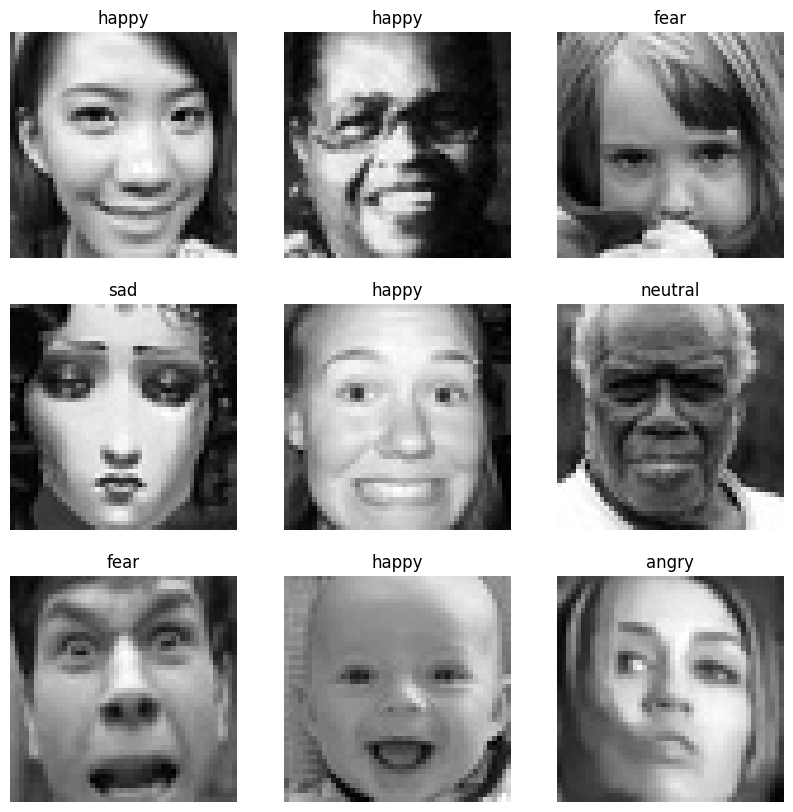

In [7]:
# Trực quan hóa dữ liệu
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = image_batch[i].numpy().transpose((1, 2, 0))
    minv = img.min()
    maxv = img.max()
    plt.imshow(np.squeeze(img), vmin=minv, vmax=maxv, cmap="gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis("off")
plt.show()

# Xây dựng mạng MLP


class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(input_dims, hidden_dims * 4)
        self.linear2 = nn.Linear(hidden_dims * 4, hidden_dims * 2)
        self.linear3 = nn.Linear(hidden_dims * 2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        out = self.output(x)
        return out


input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

# Khai báo hàm loss và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [8]:
# Xây dựng hàm tính độ chính xác
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy


# Huấn luyện mô hình
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'EPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')

EPOCH 1:	Training loss: 1.932	Validation loss: 1.914
EPOCH 2:	Training loss: 1.899	Validation loss: 1.885
EPOCH 3:	Training loss: 1.872	Validation loss: 1.860
EPOCH 4:	Training loss: 1.849	Validation loss: 1.841
EPOCH 5:	Training loss: 1.831	Validation loss: 1.826
EPOCH 6:	Training loss: 1.817	Validation loss: 1.814
EPOCH 7:	Training loss: 1.806	Validation loss: 1.806
EPOCH 8:	Training loss: 1.798	Validation loss: 1.799
EPOCH 9:	Training loss: 1.791	Validation loss: 1.793
EPOCH 10:	Training loss: 1.786	Validation loss: 1.788
EPOCH 11:	Training loss: 1.781	Validation loss: 1.784
EPOCH 12:	Training loss: 1.776	Validation loss: 1.780
EPOCH 13:	Training loss: 1.772	Validation loss: 1.776
EPOCH 14:	Training loss: 1.769	Validation loss: 1.772
EPOCH 15:	Training loss: 1.765	Validation loss: 1.768
EPOCH 16:	Training loss: 1.760	Validation loss: 1.763
EPOCH 17:	Training loss: 1.755	Validation loss: 1.757
EPOCH 18:	Training loss: 1.749	Validation loss: 1.750
EPOCH 19:	Training loss: 1.742	Valida

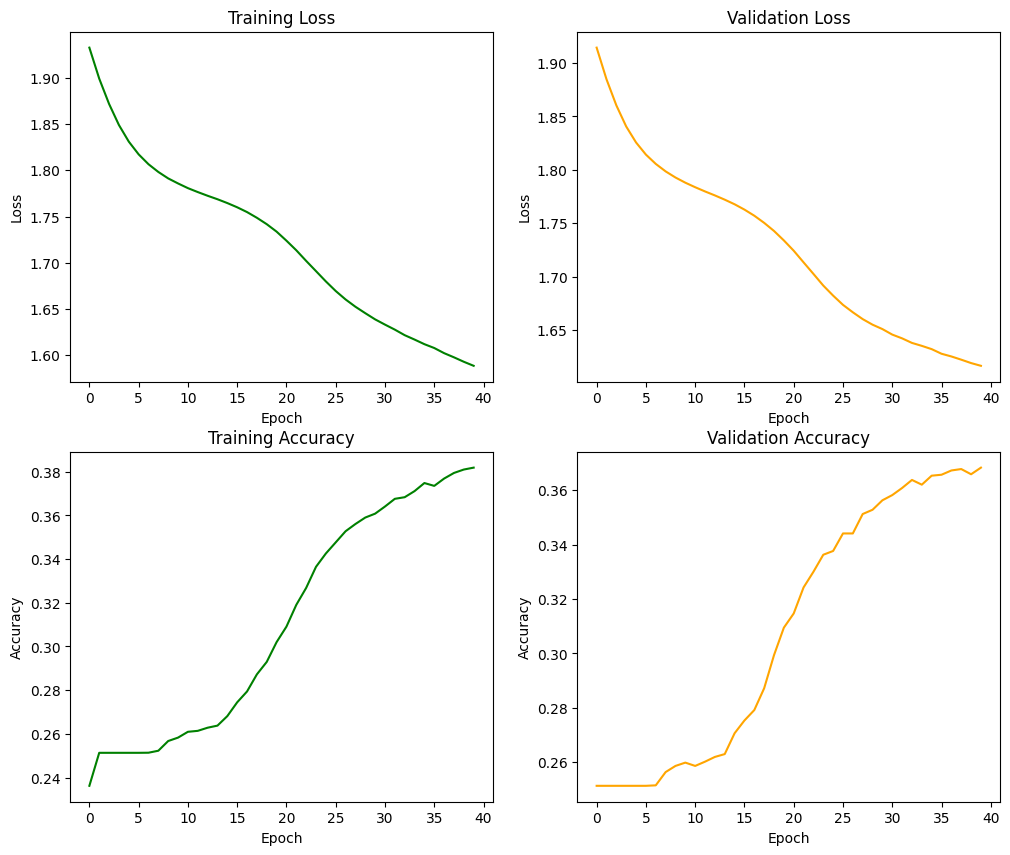

In [9]:
# Trực quan hóa kết quả huấn luyện
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

Evaluation on test set:
Accuracy: 0.3839509612705489


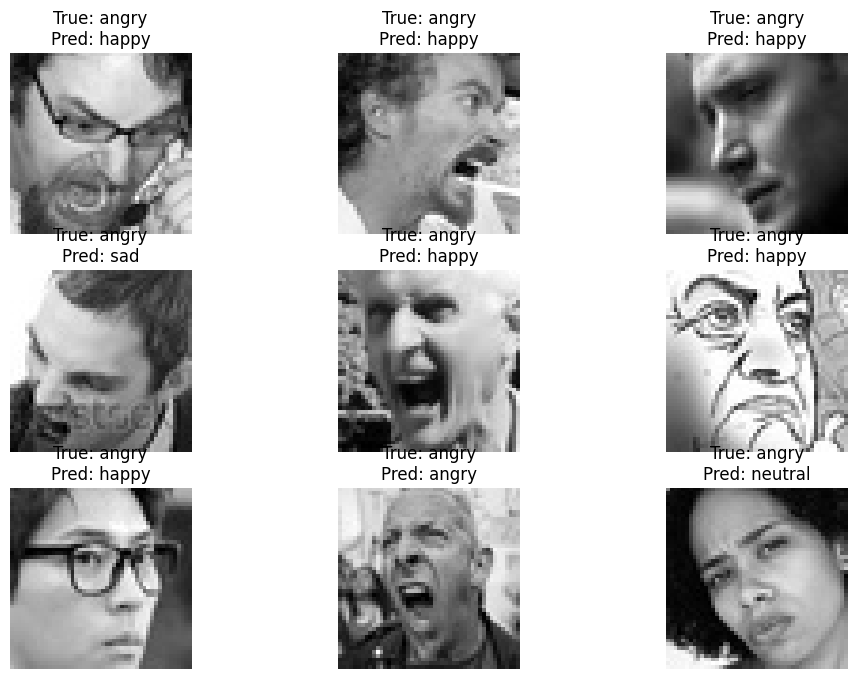

In [10]:
# Đánh giá mô hình trên tập test
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_predict, test_target)
print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

# Trực quan hóa một số kết quả dự đoán
_, predicted_labels = torch.max(test_predict, dim=1)
X_test_np = test_dataset.img_paths

plt.figure(figsize=(12, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = cv2.imread(X_test_np[i], cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    true_label = idx2label[test_target[i].item()]
    pred_label = idx2label[predicted_labels[i].item()]
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()